# Introduction: GNN for molecules

This example will showcase how to define and evaluate a GNN-like model in PyNeuraLogic on a sample molecule classification task.

Install PyNeuraLogic from PyPI

In [ ]:
! pip install neuralogic

## A Relational Dataset

We are going to use one of the predefined datasets called [Mutagenesis](https://www.doc.ic.ac.uk/~shm/mutagenesis.html). This popular dataset contains information about molecules that we are going to classify for mutagenicity on Salmonella typhimurium.

Predefined datasets are located in `neuralogic.utils.data`, and by calling `Mutagenesis`, we retrieve a tuple containing the input data (dataset) as well as a default template (rules). For this example, we are going to ignore the template as we will practice defining our own.

In [1]:
from neuralogic.utils.data import Mutagenesis

_, dataset = Mutagenesis()

Predefined examples are loaded from a file. We can check the first sample to get an idea how the data look like.

In [2]:
with open(dataset.examples_file) as fp:
    print(fp.readline())

bond(d59_23, d59_5, 0), h(d59_23), c(d59_5), b_1(0), bond(d59_5, d59_23, 0), bond(d59_20, d59_19, 1), c(d59_20), c(d59_19), b_7(1), bond(d59_19, d59_20, 1), bond(d59_10, d59_3, 2), c(d59_10), c(d59_3), b_7(2), bond(d59_3, d59_10, 2), bond(d59_14, d59_10, 3), c(d59_14), b_7(3), bond(d59_10, d59_14, 3), bond(d59_4, d59_3, 4), c(d59_4), b_7(4), bond(d59_3, d59_4, 4), bond(d59_10, d59_9, 5), c(d59_9), b_7(5), bond(d59_9, d59_10, 5), bond(d59_15, d59_28, 6), c(d59_15), h(d59_28), b_1(6), bond(d59_28, d59_15, 6), bond(d59_12, d59_13, 7), c(d59_12), c(d59_13), b_7(7), bond(d59_13, d59_12, 7), bond(d59_8, d59_9, 8), c(d59_8), b_7(8), bond(d59_9, d59_8, 8), bond(d59_7, d59_25, 9), c(d59_7), h(d59_25), b_1(9), bond(d59_25, d59_7, 9), bond(d59_30, d59_17, 10), h(d59_30), c(d59_17), b_1(10), bond(d59_17, d59_30, 10), bond(d59_15, d59_12, 11), b_7(11), bond(d59_12, d59_15, 11), bond(d59_2, d59_1, 12), c(d59_2), c(d59_1), b_7(12), bond(d59_1, d59_2, 12), bond(d59_17, d59_16, 13), c(d59_16), b_7(13),

As can be seen, the molecules are essentially encoded as heterogeneous graphs with edges called `bonds`, where the first two terms are the chemical atom ids, and the third term is the bond id. The atoms' ids are then associated with specific atom types, such as `h` for hydrogen. Bond ids are then associated with bond types, such as `b_1` for a single bond, etc.

\* Note that this textual storage format is just a bit more compact version of the way we would encode the data directly in the PyNeuraLogic language (Python), where we would instead write:

```
Relation.bond(Term.d59_23, Term.d59_5, 0), Relation.h(Term.d59_23), ...
```

Next we take a look at the associated *queries* which are the target labels associated with the examples in supervised learning scenarios.

In [3]:
with open(dataset.queries_file) as fp:
    print(fp.readline())

1.0 predict.



we can see that each example molecule is associated with just a simple binary label called 'predict' here.

<sup>
* Note that in general you can associate each example with multiple different queries (e.g. joint classification), and that these can also be structured.
<sup>

## A Relational Template

The specification of the learning template is now up to the user. This is where you can get creative, but any valid template has to somehow connect the input example representations with the output queries (i.e. the 'predict' label).
In this example, we are going to first turn the atom and bond types into embeddings, and then propagate these jointly through the molecular graphs in a GNN-like fashion.

So let's start by embedding each chemical atom type into an `atom_embed` relation with a unique learnable parameter vector of shape `[3]` (a 3-dimensional embedding).
Doing this for each type can be simplified with list comprehension.

In [4]:
from neuralogic.core import Template, R, V

template = Template()

template.add_rules([
    (R.atom_embed(V.A)[3,] <= R.get(atom)(V.A)) for atom in ["c", "o", "br", "i", "f", "h", "n", "cl"]
])

print(template)

{3} atom_embed(A) :- c(A).
{3} atom_embed(A) :- o(A).
{3} atom_embed(A) :- br(A).
{3} atom_embed(A) :- i(A).
{3} atom_embed(A) :- f(A).
{3} atom_embed(A) :- h(A).
{3} atom_embed(A) :- n(A).
{3} atom_embed(A) :- cl(A).


In the same way, we can encode the embeddings for the bonds.

In [5]:
template.add_rules([
    (R.bond_embed(V.B)[3,] <= R.get(bond)(V.B)) for bond in ["b_1", "b_2", "b_3", "b_4", "b_5", "b_7"]
])

Next we add the GNN-like graph propagation rule itself.
Particularly, we will want to project representations of all the nodes (`atom_embed`) through a learnable matrix of shape `[3, 3]`.
We will do this separately for the "central" node `X` and its neighbors `Y` (nodes connected by the `bond` relation) to accommodate for their different roles here.
Since we also have different bond types here, we will combine these atom projections together with the bond embedding.
For each central node `X`, we will then aggregate these representations from all the corresponding neighbors `Y`, to serve as the new representation for the central node `X`.
Let's call this resulting representation `layer_1`.

In [6]:
template +=  R.layer_1(V.X) <= (R.atom_embed(V.X)[3, 3], R.atom_embed(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B))

In the same way, we can now add some more "layers" that will be 'connected' by utilizing the previously defined representations.

In [7]:
template +=  R.layer_2(V.X) <= (R.layer_1(V.X)[3, 3], R.layer_1(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B))
template +=  R.layer_3(V.X) <= (R.layer_2(V.X)[3, 3], R.layer_2(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B))

Finally, to obatin a single label for the whole graph, we then aggregate all the nodes' (atoms') representations from the last layer (`layer_3`), and project them through another learnable vector of shape `[1, 3]` into a scalar value.
We will call the resulting representation `predict` to correspond to the learning target queries given in the dataset.

In [8]:
template += R.predict[1, 3] <= R.layer_3(V.X)

print(template)

{3} atom_embed(A) :- c(A).
{3} atom_embed(A) :- o(A).
{3} atom_embed(A) :- br(A).
{3} atom_embed(A) :- i(A).
{3} atom_embed(A) :- f(A).
{3} atom_embed(A) :- h(A).
{3} atom_embed(A) :- n(A).
{3} atom_embed(A) :- cl(A).
{3} bond_embed(B) :- b_1(B).
{3} bond_embed(B) :- b_2(B).
{3} bond_embed(B) :- b_3(B).
{3} bond_embed(B) :- b_4(B).
{3} bond_embed(B) :- b_5(B).
{3} bond_embed(B) :- b_7(B).
layer_1(X) :- {3, 3} atom_embed(X), {3, 3} atom_embed(Y), bond(X, Y, B), bond_embed(B).
layer_2(X) :- {3, 3} layer_1(X), {3, 3} layer_1(Y), bond(X, Y, B), bond_embed(B).
layer_3(X) :- {3, 3} layer_2(X), {3, 3} layer_2(Y), bond(X, Y, B), bond_embed(B).
{1, 3} predict :- layer_3(X).


We can also take a look at the template visually.

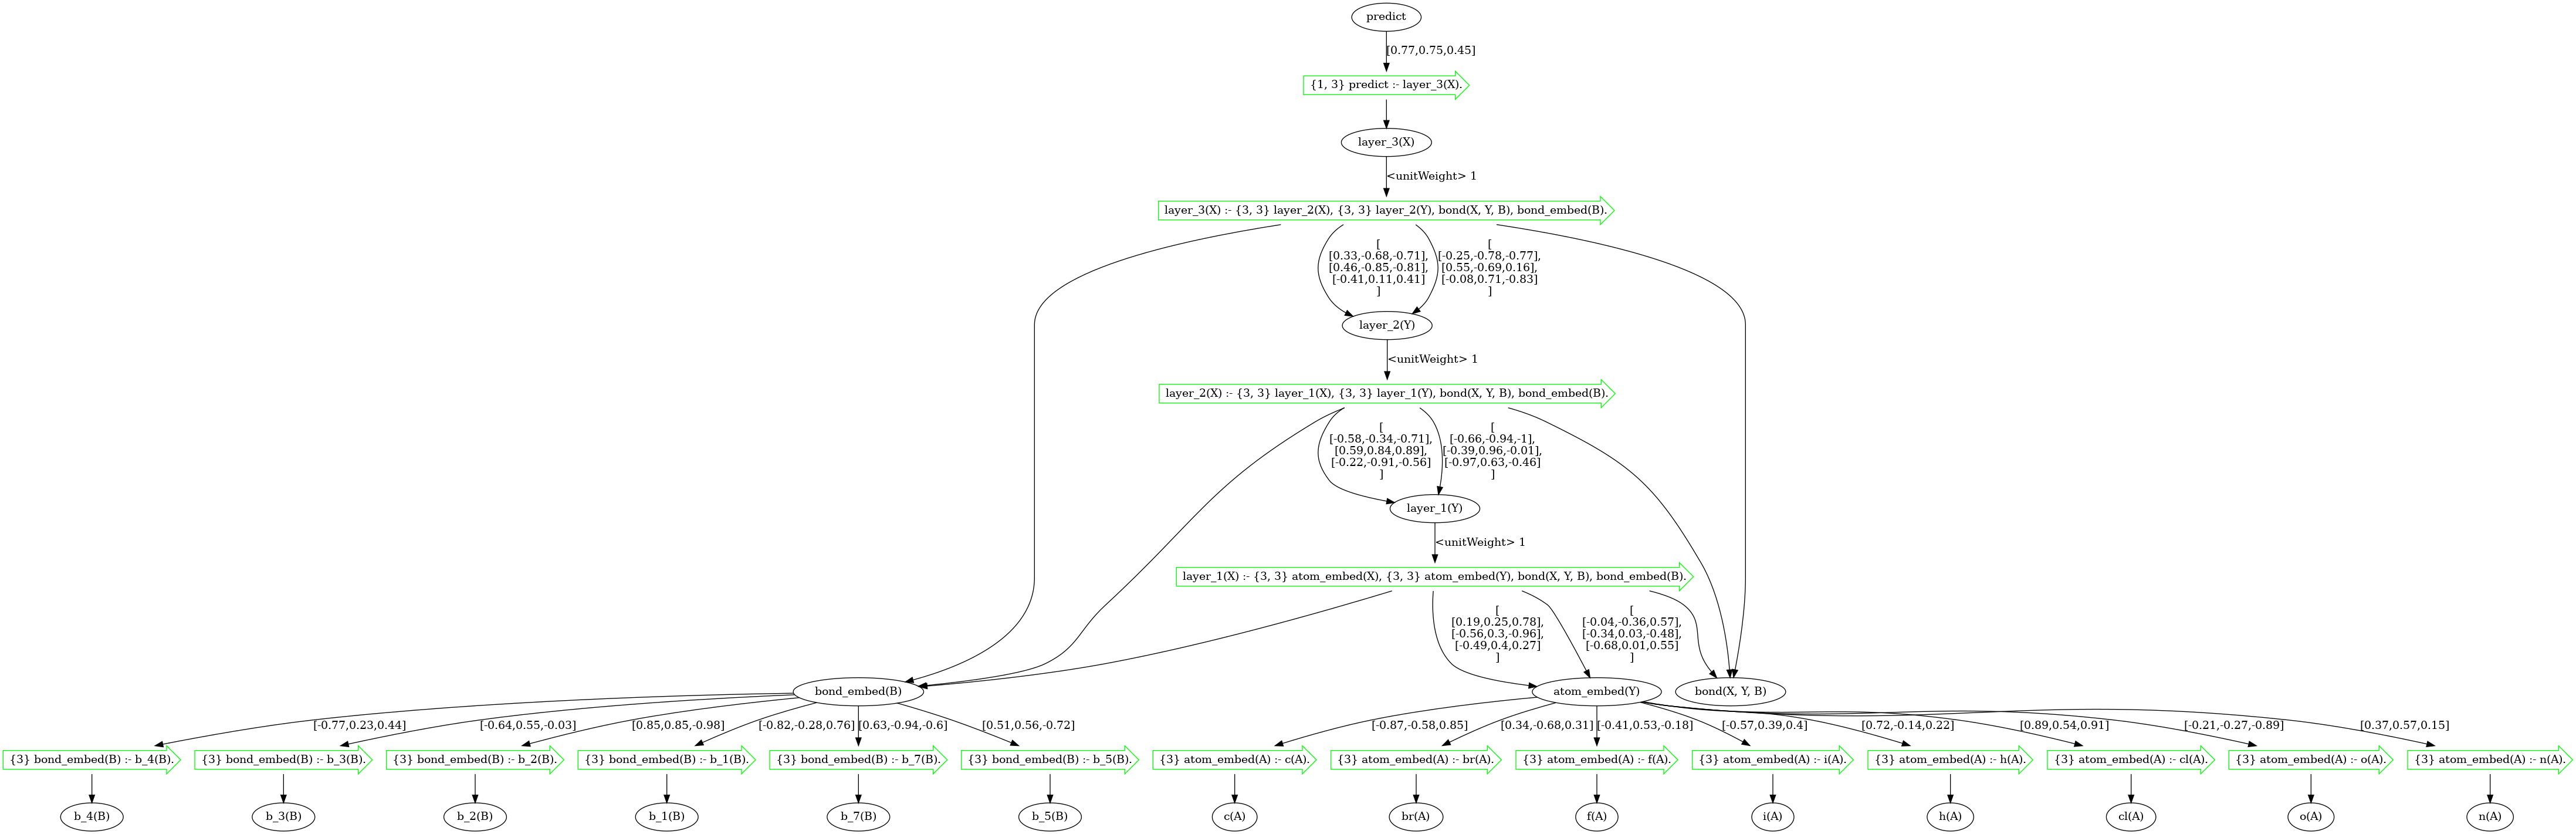

In [9]:
template.draw()

## Training

When we have our dataset and template ready, it's time to build ("ground") the template over the dataset and start training.
We can do the training manually and write our own custom training loop, but we can also use predefined helpers - *evaluators*,
that handle model and dataset building, training, and more. Evaluators can be customized via `Settings`.

<sup>Note that building the dataset (=grounding the logic rules and translating into neural networks) may take a while, depending on the complexity of your template.
But this is only done once before the training itself, which takes up most of the time anyway.
<sup>

In [10]:
from neuralogic.core import Settings, Optimizer
from neuralogic.nn.loss import MSE, CrossEntropy
from neuralogic.nn import get_evaluator

settings = Settings(optimizer=Optimizer.ADAM, epochs=100, learning_rate=0.001, error_function=MSE())
evaluator = get_evaluator(template, settings)

built_dataset = evaluator.build_dataset(dataset)

Finally, we iterate through the iterator encapsulated in the `train` method of the evaluator, which yields a total loss of the epoch and the number of samples of the current epoch.
We then get access to the results from the training loop that we can further visualize, inspect, log, etc.

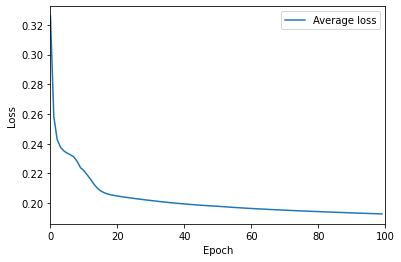

In [11]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

average_losses = []

for current_total_loss, number_of_samples in evaluator.train(built_dataset):
    clear_output(wait=True)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.xlim(0, settings.epochs)

    average_losses.append(current_total_loss / number_of_samples)
    
    plt.plot(average_losses, label="Average loss")

    plt.legend()
    plt.pause(0.001)
    plt.show()

We can then check the trained model predictions (for the same sample set here) by utilizing the `test` method.

In [12]:
for sample, y_hat in zip(built_dataset.samples, evaluator.test(built_dataset)):
    print(f"Target: {sample.java_sample.target}, Predicted: {round(y_hat)} ({y_hat})")

Target: 1, Predicted: 1 (0.6795890023999056)
Target: 1, Predicted: 1 (0.6795888714179736)
Target: 1, Predicted: 1 (0.5372628320236608)
Target: 1, Predicted: 1 (0.6795909059281575)
Target: 1, Predicted: 0 (0.2877981408383103)
Target: 1, Predicted: 1 (0.6795933046287176)
Target: 1, Predicted: 1 (0.6795933047121888)
Target: 1, Predicted: 1 (0.6795865847796555)
Target: 1, Predicted: 1 (0.5575699317350188)
Target: 1, Predicted: 1 (0.524671416565774)
Target: 1, Predicted: 1 (0.6047656189994708)
Target: 1, Predicted: 1 (0.6795830147965539)
Target: 1, Predicted: 1 (0.6078901997910687)
Target: 1, Predicted: 1 (0.6078901998751124)
Target: 1, Predicted: 1 (0.6795866086078238)
Target: 1, Predicted: 1 (0.557323147063217)
Target: 1, Predicted: 1 (0.6795948889205353)
Target: 1, Predicted: 0 (0.4848805748295847)
Target: 1, Predicted: 1 (0.6079762611480644)
Target: 1, Predicted: 1 (0.6159019660439232)
Target: 1, Predicted: 1 (0.6795890023413627)
Target: 1, Predicted: 1 (0.6795909124963126)
Target: 1, P